# imports and defs

In [1]:
import utility_module_2_v_3 as uu
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy.matlib as ml

In [2]:
path_imd='/media/vikram/subimal/Raw_Data/IMD_DATA/'
path_gcm = '/media/vikram/subimal/Raw_Data/GCM_BCSD_DATA/'
path_out = '/home/vikram/BCSD_data/India_P_CH/'


# Read IMD  data

## Read data

In [3]:
data_bounds=[65, 40, 100, 5]
st=1951
en=2005
 
data_imd_obs,m,lat_obs,lon_obs=uu.extract_imd_rainfall_nc(st,en,path_imd+'/rainfall_pt1/',data_bounds)

mask=np.all(m,axis=0)


dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
dict_keys(['LONGITUDE', 'LATITUDE', 'TIME', 'RAINFALL'])
dict_keys(['LONGITUDE', 'LATITU

## Data check

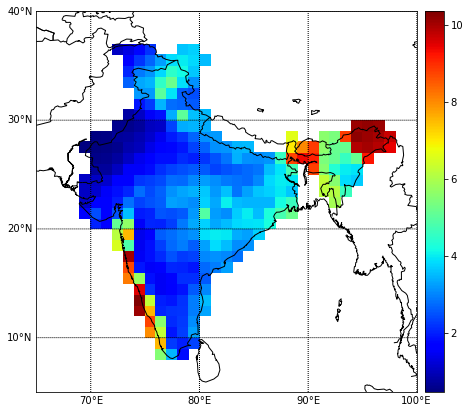

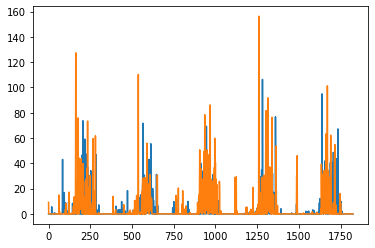

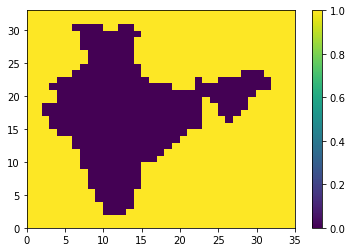

In [4]:
# plot spatial
map_bounds=data_bounds
mp_spacing=10
uu.map_plot_cyl(np.mean(data_imd_obs[:,:,:],axis=0),lat_obs,lon_obs,map_bounds,mp_spacing=10)

# plot temporal
plt.plot(data_imd_obs[:365*5,15,15])
plt.plot(data_imd_obs[-365*5:,15,15])

# plot mask
plt.figure()
plt.pcolor(mask)
plt.colorbar()

## Fill outside the mask

In [5]:
def create_distance_matrix(M,N,ii,jj):
  D=np.ones((M,N))*10000000
  for i in range(M):
    for j in range(N):
      D[i,j]=np.abs(i-ii)**2+0.1*np.abs(j-jj)**2
  return D

N1=data_imd_obs.shape[1]
N2=data_imd_obs.shape[2]

data_new=data_imd_obs.data+0.0001
for i in range(N1):
  for j in range(N2):
    if mask[i,j]==1:
      a=create_distance_matrix(N1,N2,i,j)+1000000*mask
      i_min,j_min= np.unravel_index(a.argmin(), a.shape)
      data_new[:,i,j]=data_imd_obs[:,i_min,j_min]

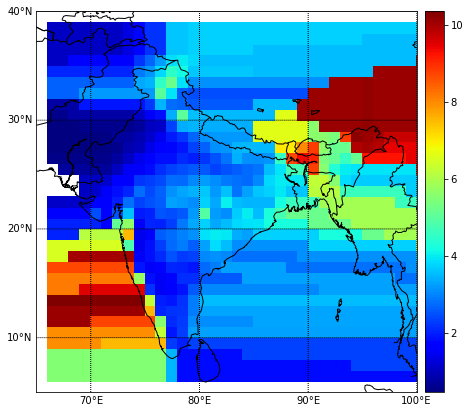

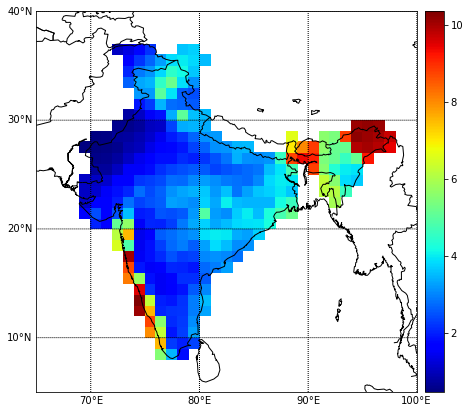

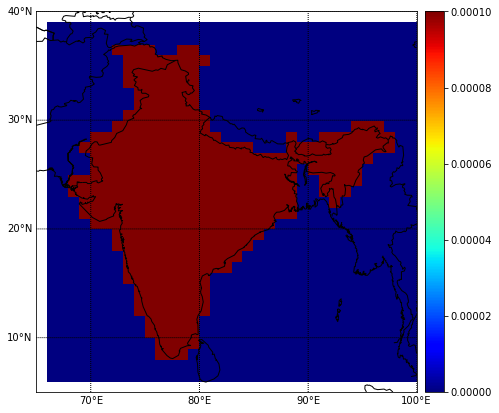

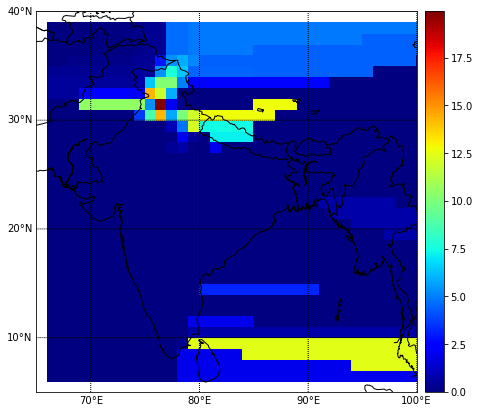

In [6]:
uu.map_plot_cyl(np.mean(data_new,axis=0),lat_obs,lon_obs,map_bounds,mp_spacing=10)
uu.map_plot_cyl(np.mean(data_imd_obs,axis=0),lat_obs,lon_obs,map_bounds,mp_spacing=10)
uu.map_plot_cyl(data_new[1,:,:],lat_obs,lon_obs,map_bounds,mp_spacing=10)
uu.map_plot_cyl(data_new[7,:,:],lat_obs,lon_obs,map_bounds,mp_spacing=10)
data_imd_obs=data_new
del data_new

## Split data

In [7]:
with np.load('/home/vikram/Dropbox/BCSD Work/07_BCSD_India_salvi/cold_warm_years.npz/cold_warm_years.npz',allow_pickle=True) as dataz:
    train_years = dataz['cold_years']
    test_years = dataz['warm_years']

    
# dti = pd.date_range( start=str(st)+'-01-01', end=str(en)+'-12-31', freq='D')
# index_train=np.any(np.array([ dti.year == x for x in train_years]),axis=0)
# index_test=np.any(np.array([ dti.year == x for x in test_years]),axis=0)
_,N1,N2 = data_imd_obs.shape

data_obs_imd_noleap_yearwise = uu.correct_nan_inf_neg(uu.remove_leap_years_sts(data_imd_obs,st,en)[0].reshape((365,-1,N1,N2),
                                       order='F'))

data_obs_imd_train  = data_obs_imd_noleap_yearwise[:,np.sort( train_years - st),:,:].reshape([-1,N1,N2]
                                                ,order = 'F' )

data_obs_imd_pred  = data_obs_imd_noleap_yearwise[:,np.sort( test_years - st),:,:].reshape([-1,N1,N2]
                                                ,order = 'F' )



# Read GCM

In [8]:
from netCDF4 import Dataset

date_ts=pd.date_range(start=str(st)+'-01-01',end=str(en)+'-12-31')
print(date_ts[0],date_ts[-1])
N=date_ts.shape[0]
print("N:1951-2005::",st,en,N,55*(365.25))

1951-01-01 00:00:00 2005-12-31 00:00:00
N:1951-2005:: 1951 2005 20089 20088.75



## MIROC_ESM

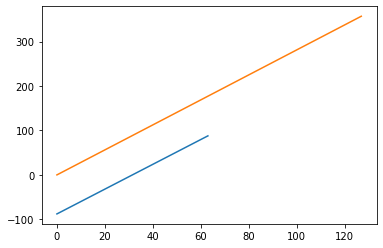

In [52]:
# reading file(s)
filename = path_gcm + '/MIROC_ESM/pr_day_MIROC-ESM_historical_r1i1p1_18500101-20051231.nc'
fh = Dataset(filename, mode='r')
lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]
plt.plot(lats)
plt.plot(lons)
# cropping the study area out
l_lat,u_lat,lat_gcm=uu.find_bounds(lats,data_bounds[3],data_bounds[1])
l_lon,u_lon,lon_gcm=uu.find_bounds(lons,data_bounds[0],data_bounds[2])

# cropping years before 1901
st_gcm=1850
dt_data_st=np.datetime64(str(st_gcm)+'-01-01')
dt_st=np.datetime64(str(st)+'-01-01')
index_of_st=((dt_st- dt_data_st) / np.timedelta64(1, 'D')).astype(int)

data_gcm_daily = fh.variables['pr'][index_of_st:,l_lat:u_lat+1,l_lon:u_lon+1].data*3600*24



In [53]:
print(data_gcm_daily.shape,lat_gcm.shape,lon_gcm.shape,st_gcm)

(20089, 14, 14) (14,) (14,) 1850


In [54]:
gcm_name='MIROC_ESM'

## CanESM
Input file 
- contains one file \
- no leap year

20075 == 20075


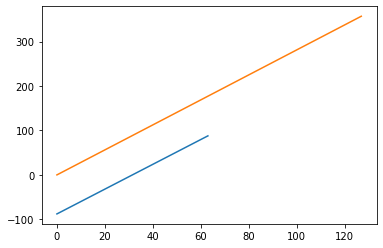

In [12]:
# reading file(s)
gcm_name='CanESM2'
filename = path_gcm + '/CanESM2/pr_day_CanESM2_historical_r1i1p1_18500101-20051231.nc'
fh = Dataset(filename, mode='r')
lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]
plt.plot(lats)
plt.plot(lons)
# cropping the study area out
l_lat,u_lat,lat_gcm=uu.find_bounds(lats,data_bounds[3],data_bounds[1])
l_lon,u_lon,lon_gcm=uu.find_bounds(lons,data_bounds[0],data_bounds[2])
# cropping years before 1901
st_gcm=1850
dt_st=st
index_of_st=(dt_st- st_gcm) *365

#print(fh)
data_gcm_daily = fh.variables['pr'][index_of_st:,l_lat:u_lat+1,l_lon:u_lon+1].data*3600*24
print(data_gcm_daily.shape[0],"==",365*55)
data_gcm_daily=uu.add_leap_years_sts(data_gcm_daily,st,en)[0]

In [13]:
print(data_gcm_daily.shape,N-data_gcm_daily.shape[0],lat_gcm.shape,lon_gcm.shape,st_gcm)

(20089, 14, 14) 0 (14,) (14,) 1850


## HadGEM_AO
Input file
- 30 days for each month


In [11]:

filename = '/content/drive/MyDrive/GCM data/HadGEM2_AO/pr_day_HadGEM2-AO_historical_r1i1p1_18600101-20051230.nc'
#splitting into training and testing section
fh = Dataset(filename, mode='r')
lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]
plt.plot(lats)
plt.plot(lons)

# cropping the study area out
l_lat,u_lat,lat_gcm=uu.find_bounds(lats,data_bounds[3],data_bounds[1])
l_lon,u_lon,lon_gcm=uu.find_bounds(lons,data_bounds[0],data_bounds[2])

# cropping years before 1901
st_gcm=1860
dt_st=st
index_of_st=(dt_st- st_gcm) *360

data_daily=fh.variables['pr'][index_of_st:,l_lat:u_lat+1,l_lon:u_lon+1].data*3600*24
print(data_daily.shape[0],"==",360*105)

N1,N2=data_daily.shape[1],data_daily.shape[2]
data_daily=data_daily.reshape([360,105,N1,N2],order='F')

data_gcm_daily=np.empty(shape=[365,105,N1,N2])

mat=np.ones([365])
mat[[60,121,182,243,304]]=0
data_gcm_daily[mat==1,:,:,:]=data_daily
data_gcm_daily[[60,121,182,243,304],:,:,:]=data_gcm_daily[[61,122,183,244,305],:,:,:]
del data_daily
data_gcm_daily=data_gcm_daily.reshape([-1,N1,N2],order='F')
data_gcm_daily=uu.add_leap_years_sts(data_gcm_daily,st,en)[0]


FileNotFoundError: [Errno 2] No such file or directory: b'/content/drive/MyDrive/GCM data/HadGEM2_AO/pr_day_HadGEM2-AO_historical_r1i1p1_18600101-20051230.nc'

In [ ]:
print(data_gcm_daily.shape,N-data_gcm_daily.shape[0],lat_gcm.shape,lon_gcm.shape,st_gcm)

In [ ]:
gcm_name='HadGEM_AO'

## GFDL_CM3
Input files:
- 5 year files
- no leap years
tobe fixed fo start date of simulations

In [ ]:
gcm_name='GFDL_CM3'
st_gcm=1901
def get_fname(var,str1,str2):
  url='/content/drive/MyDrive/GCM data/GFDL_CM3/'+var+'_day_GFDL-CM3_historical_r1i1p1_'+str1+'-'+str2+'.nc'
  return url

delta=5
def get_urls(var):
  fname_list=[]
  for yeaR in range(1900,2004,delta):
    str1=str(yeaR)+'0101'
    str2=str(yeaR+delta-1)+'1231'
    
    fname_list.append(get_fname(var,str1,str2))

  str1=str(2005)+'0101'
  str2=str(2005)+'1231'
  
  fname_list.append(get_fname(var,str1,str2))
  return fname_list


fnames=get_urls('pr')

In [ ]:
# reading file(s)
filename = fnames[0]
fh = Dataset(filename, mode='r')
lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]
plt.plot(lats)
plt.plot(lons)
# cropping the study area out
l_lat,u_lat,lat_gcm=uu.find_bounds(lats,data_bounds[3],data_bounds[1])
l_lon,u_lon,lon_gcm=uu.find_bounds(lons,data_bounds[0],data_bounds[2])

for i in range(len(fnames)):
  filename = fnames[i]
  fh = Dataset(filename, mode='r')
  lons = fh.variables['lon'][:]
  lats = fh.variables['lat'][:]
  #print(fh)
  data = fh.variables['pr'][:,l_lat:u_lat+1,l_lon:u_lon+1].data * 3600*24

  if i==0:
    # starts at 1901
    data_gcm_daily=data[365:,:,:]
  else:
    data_gcm_daily=np.concatenate((data_gcm_daily,data),axis=0)
data_gcm_daily=uu.add_leap_years_sts(data_gcm_daily,st,en)[0]

print('Tessting\n\n\n\n\n\n\n\ check !!!!!!!!!!!!!!!!!!!!!!!!1 \n\n\n and delete this')

dt_data_st=np.datetime64(str(1901)+'-01-01')
dt_st=np.datetime64(str(st)+'-01-01')
dt_en=np.datetime64(str(en+1)+'-01-01')

index_of_st=((dt_st- dt_data_st) / np.timedelta64(1, 'D')).astype(int)
index_of_en=((dt_en-dt_data_st) / np.timedelta64(1, 'D')).astype(int)

data_gcm_daily = data_gcm_daily[index_of_st:index_of_en,:,:]

In [ ]:
print(data_gcm_daily.shape,N-data_gcm_daily.shape[0],lat_gcm.shape,lon_gcm.shape,st_gcm)

## plot check data

(20089, 14, 14) (20089,) (14,) (14,)


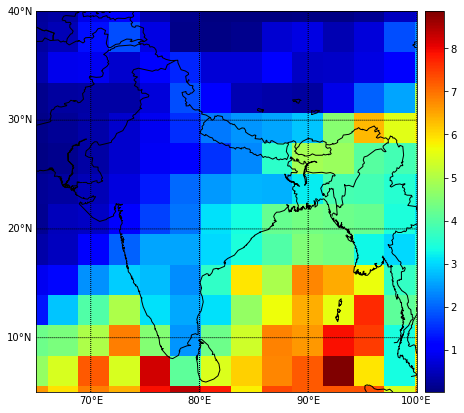

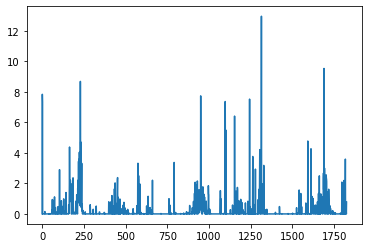

In [14]:
## check dimensions and plot ts
date_ts=pd.date_range(start=str(st)+'-01-01',end=str(en)+'-12-31')

print(data_gcm_daily.shape,date_ts.shape,lat_gcm.shape,lon_gcm.shape)

#plotting
map_bounds=data_bounds #[50 , 50, 110, 0] #ltrb
mp_spacing=10
uu.map_plot_cyl(np.mean(data_gcm_daily[:,:,:],axis=0),lat_gcm,lon_gcm,map_bounds,mp_spacing=10)

plt.figure()
plt.plot(data_gcm_daily[:365*5,10,9])

## split data

In [15]:
data_gcm_daily.shape

(20089, 14, 14)

In [16]:
# #splitting into training and testing section
# dt_data_st=np.datetime64(str(1901)+'-01-01')

# dt_st=np.datetime64(str(st)+'-01-01')
# dt_en=np.datetime64(str(en+1)+'-01-01')

# index_of_st=((dt_st- dt_data_st) / np.timedelta64(1, 'D')).astype(int)
# index_of_en=((dt_en-dt_data_st) / np.timedelta64(1, 'D')).astype(int)



In [17]:



_,N1,N2 = data_gcm_daily.shape

data_gcm_daily_noleap_yearwise = uu.correct_nan_inf_neg(uu.remove_leap_years_sts(data_gcm_daily,st,en)[0].reshape((365,-1,N1,N2),
                                       order='F'))

data_gcm_train  = data_gcm_daily_noleap_yearwise[:,np.sort( train_years - st),:,:].reshape([-1,N1,N2]
                                                ,order = 'F' )

data_gcm_pred  = data_gcm_daily_noleap_yearwise[:,np.sort( test_years - st),:,:].reshape([-1,N1,N2]
                                                ,order = 'F' )


# data_gcm_train=uu.correct_nan_inf_neg(data_gcm_daily[index_train,:,:])
# data_gcm_pred=uu.correct_nan_inf_neg(data_gcm_daily[index_test,:,:])

# print(data_gcm_daily.shape,data_gcm_train.shape,data_gcm_pred.shape)

# Writing Variables

In [18]:
np.save(path_out + '/data_obs_imd_train',data_obs_imd_train)


data_obs_imd_pred_coarse=np.zeros((data_obs_imd_pred.shape[0],data_gcm_pred.shape[1],data_gcm_pred.shape[2]))

for i in range(data_obs_imd_pred.shape[0]):
  data_obs_imd_pred_coarse[i,:,:]=uu.regrid(data_obs_imd_pred[i,:,:],lat_obs,lon_obs,lat_gcm,lon_gcm)

np.save(path_out + '/data_obs_imd_'+gcm_name+'_pred_coarse',data_obs_imd_pred_coarse)
np.save(path_out + '/data_obs_imd_pred',data_obs_imd_pred)
np.save(path_out + '/data_gcm_'+gcm_name+'_imd_pred',data_gcm_pred)
np.save(path_out + '/data_gcm_'+gcm_name+'_imd_train',data_gcm_train)

dic={'st':st,
     'en':en,
     'mask':mask,
     'lat_obs':lat_obs,
     'lat_gcm':lat_gcm,
     'lon_obs':lon_obs,
     'lon_gcm':lon_gcm}     
     
np.save(path_out + '/bcsd_imd_metadata_'+gcm_name,dic)


 # BC

In [19]:
import time
import scipy
from scipy.stats import gamma

In [26]:

def bias_corr_historical_with_zeros_train(data_grid_obs,data_grid_hist_train,data_grid_hist_pred):
  '''
  -> bias correction of a univariate time series
  -> does not care about daily/ monthly
  '''
  #print('start')
  var_data_obs = data_grid_obs
  var_data_hist_train = data_grid_hist_train
  var_data_hist_pred = data_grid_hist_pred

  var_data_obs[var_data_obs<0]=0
  var_data_hist_train[var_data_hist_train<0]=0
  var_data_hist_pred[var_data_hist_pred<0]=0
  #print('NaNs fixed:',np.sum(np.isnan(var_data_obs)), np.sum(np.isnan(var_data_hist_train)),np.sum(np.isnan(var_data_hist_pred)) )
  var_data_obs[np.isnan(var_data_obs)]=0
  var_data_hist_train[np.isnan(var_data_hist_train)]=0
  var_data_hist_pred[np.isnan(var_data_hist_pred)]=0

  var_data_obs[np.isinf(var_data_obs)]=0
  var_data_hist_train[np.isinf(var_data_hist_train)]=0
  var_data_hist_pred[np.isinf(var_data_hist_pred)]=0

  bias_corr=np.zeros(var_data_hist_pred.shape[0]);

  data=var_data_hist_train
  data_non_zeros=(data[data>0])
  count_zeros=(data[data==0].shape[0])
  count_total=(data.shape[0])
  p_zeros=count_zeros/count_total
  #print('hist')
  fita,fitloc,fitscale = scipy.stats.gamma.fit(data_non_zeros,floc=0)

  data=var_data_hist_pred
  cdf= p_zeros + (1 - p_zeros) * scipy.stats.gamma.cdf(data, a=fita,loc=fitloc,scale=fitscale)

  data=var_data_obs
  data_non_zeros=(data[data>0])
  count_zeros=(data[data==0].shape[0])
  count_total=(data.shape[0])
  p_zeros_imd=count_zeros/count_total
  #print('Obs')

  ofita,ofitloc,ofitscale = scipy.stats.gamma.fit(data_non_zeros,floc=0)

  for iter in range(cdf.shape[0]):
    cdfi=cdf[iter]
    if cdfi<=p_zeros_imd:
      bias_corr[iter]=0
    else:
      z=(cdfi-p_zeros_imd)/(1-p_zeros_imd)
      bc=scipy.stats.gamma.ppf(z, a=ofita,loc=ofitloc,scale=ofitscale)
      bias_corr[iter]=bc

  return bias_corr


# 

def bias_corr_spatial_daily(data_obs,data_gcm_train,data_gcm_pred,dic):
  st=dic['st']
  en=dic['en']
  # yr_split=dic['yr_split']
  mask=dic['mask']
  
  N1=data_gcm_train.shape[1]
  N2=data_gcm_train.shape[2]
  print("bias_corr_spatial_daily:")
  print('Input size : ',list(map(np.shape,(data_obs,data_gcm_train,data_gcm_pred))))
  
  # data_obs_nl=uu.remove_leap_years_sts(data_obs,st,yr_split-1)
  # data_gcm_train_nl=uu.remove_leap_years_sts(data_gcm_train,st,yr_split-1)
  # data_gcm_pred_nl=uu.remove_leap_years_sts(data_gcm_pred,yr_split,en)

  # print('Leapyear removed',data_obs.shape,data_gcm_train_nl[0].shape,data_gcm_pred_nl[0].shape)

 ## ddifferrettn from original scrip
  data_obs_m=data_obs.flatten(order='F').reshape((365,-1,N1,N2),order='F') # DOYxNxN1xN2
  data_gcm_train_m=data_gcm_train.flatten(order='F').reshape((365,-1,N1,N2),order='F')
  data_gcm_pred_m=data_gcm_pred.flatten(order='F').reshape((365,-1,N1,N2),order='F')

  print('Reshaped',data_obs_m.shape,data_gcm_train_m.shape,data_gcm_pred_m.shape)
   
  data_obs_m_ex=np.concatenate((data_obs_m[-15:,:,:,:],data_obs_m[:,:,:,:],data_obs_m[:15,:,:,:]),axis=0)
  data_gcm_train_m_ex=np.concatenate((data_gcm_train_m[-15:,:,:,:],data_gcm_train_m[:,:,:,:],data_gcm_train_m[:15,:,:,:]),axis=0)
  data_gcm_pred_m_ex=np.concatenate((data_gcm_pred_m[-15:,:,:,:],data_gcm_pred_m[:,:,:,:],data_gcm_pred_m[:15,:,:,:]),axis=0)
  data_bc_gcm=np.empty_like(data_gcm_pred_m)
  
  # del data_obs_nl
  # del data_gcm_train_nl
  # del data_gcm_pred_nl

  del data_obs_m
  del data_gcm_train_m
  del data_gcm_pred_m

  print('Appended',data_obs_m_ex.shape,data_gcm_pred_m_ex.shape,data_gcm_train_m_ex.shape)
  # print(N1,N2)
  for i in range(N1):
    for j in range(N2):
      #print('#1')
      #print(j)

      for day_iter in range(365):

        #print('Day iter:',day_iter)
        va=data_obs_m_ex[day_iter:day_iter+31,:,i,j].flatten(order='F')
        vb=data_gcm_train_m_ex[day_iter:day_iter+31,:,i,j].flatten(order='F')
        vc=data_gcm_pred_m_ex[day_iter:day_iter+31,:,i,j].flatten(order='F')
        #print('va',va.shape)
        #print('va',vb.shape)
        #print('va',vc.shape)
        
        data_bc_gcm[day_iter,:,i,j]=bias_corr_historical_with_zeros_train(va,vb,vc).flatten(order='F').reshape((31,-1),order='F')[15,:]


    print('BC:',(i+1)/N1*100,'% completed')
  return data_bc_gcm.flatten(order='F').reshape((-1,N1,N2),order='F')
 

#SD

In [27]:
 
def calculate_mean_anom_field_daily(data_obs,dic):

  lat_obs=dic['lat_obs']
  lat_gcm=dic['lat_gcm']
  lon_obs=dic['lon_obs']
  lon_gcm=dic['lon_gcm'] 

  N=data_obs.shape[0]
  N1=data_obs.shape[1]
  N2=data_obs.shape[2]

  N1g=lat_gcm.shape[0]
  N2g=lon_gcm.shape[0]

  data_fined_obs_coarse=np.zeros((N,N1,N2))
  for i in range(N):

    data_obs_coarse=uu.regrid(data_obs[i,:,:],lat_obs,lon_obs,lat_gcm,lon_gcm)
    data_fined_obs_coarse[i,:,:]=uu.regrid(data_obs_coarse,lat_gcm,lon_gcm,lat_obs,lon_obs)
  del data_obs_coarse
  # q11=uu.remove_leap_years_sts(data_obs,yr_split,en)[0]
  # del data_obs
  # q22=uu.remove_leap_years_sts(data_fined_obs_coarse,yr_split,en)[0]
  # del data_fined_obs_coarse

  q1=data_obs.flatten(order='F').reshape((365,-1,N1,N2),order='F').mean(axis=1)
  # del q11
  q2=data_fined_obs_coarse.flatten(order='F').reshape((365,-1,N1,N2),order='F').mean(axis=1)
  # del q22

  q1=q1-q2
  del q2
  return q1

def spatial_diaggregation(data_bc_gcm,anom,dic):
# def spatial_diaggregation(data_bc_gcm,data_obs_fine,anom,dic):
# data_obs_fine not needed
  lat_obs=dic['lat_obs']
  lat_gcm=dic['lat_gcm']
  lon_obs=dic['lon_obs']
  lon_gcm=dic['lon_gcm'] 

  data_fined_bc_gcm=uu.regrid(data_bc_gcm,lat_gcm,lon_gcm,lat_obs,lon_obs)
  sd_output=data_fined_bc_gcm+anom

  #data_obs_coarse=uu.regrid(data_obs_fine,lat_obs,lon_obs,lat_gcm,lon_gcm)
  #data_fined_obs_coarse=uu.regrid(data_obs_coarse,lat_gcm,lon_gcm,lat_obs,lon_obs)
  #data_fined_bc_gcm=uu.regrid(data_bc_gcm,lat_gcm,lon_gcm,lat_obs,lon_obs)
  #agg_anomoly_sc=data_fined_bc_gcm+(data_obs_fine-data_fined_obs_coarse)
  #print('data_bc_gcm')
  #uu.map_plot_cyl(data_bc_gcm,lat_gcm,lon_gcm,map_bounds,mp_spacing=10)
  #print('data_obs_fine')
  #uu.map_plot_cyl(data_obs_fine,lat_obs,lon_obs,map_bounds,mp_spacing=10)
  #print('data_fined_bc_gcm')
  #uu.map_plot_cyl(data_fined_bc_gcm,lat_obs,lon_obs,map_bounds,mp_spacing=10)
  #print('sd_output')
  #uu.map_plot_cyl(sd_output,lat_obs,lon_obs,map_bounds,mp_spacing=10)

  return sd_output
  

def spatial_diaggregation_extended(data_gcm_bc,data_obs_ncar,dic):
  st=dic['st']
  en=dic['en']
  # yr_split=dic['yr_split']

  lat_obs=dic['lat_obs']
  lat_gcm=dic['lat_gcm']
  lon_obs=dic['lon_obs']
  lon_gcm=dic['lon_gcm'] 

  data_return=np.zeros((data_gcm_bc.shape[0],data_obs_ncar.shape[1],data_obs_ncar.shape[2],))
  N=data_gcm_bc.shape[0]

  anom=calculate_mean_anom_field_daily(data_obs_ncar,dic)

  dat2=ml.repmat( np.arange(365), 27*2, 1).flatten()
  # dat2=uu.add_leap_years(dat,yr_split,en)[0]

  for i in range(N):

    z=data_gcm_bc[i,:,:]
    # zz=data_obs_ncar[1,:,:]
    data_return[i,:,:]=spatial_diaggregation(z,anom[int(dat2[i])],dic)
    if i%100==0:
      print('SD:',(i+1)/N*100,'% completed')

  return data_return

#uu.map_plot_cyl(zz,ynew,xnew,map_bounds,mp_spacing=10)
#data_bcsd_pred=spatial_diaggregation_extended(data_gcm_bc_pred,data_obs_ncar_pred)

  

# BCSD

In [28]:
def correct_nan_inf_neg_sts(data_prec):
    data_prec[data_prec<0]=0

    data_prec[np.isnan(data_prec)]=0

    data_prec[np.isinf(data_prec)]=0  
    
    import copy
    _,N1,N2 = data_prec.shape

    for n1 in range(N1):
        for n2 in range(N2):
            temp = copy.deepcopy(data_prec[:,n1,n2])
            temp[np.isinf(temp)] = np.nan
            data_prec[np.isinf(data_prec[:,n1,n2]),n1,n2]   =  np.nanmax(temp)
    del temp
    return data_prec 



In [29]:

def bcsd(out_id,data_obs_ncar_train,data_obs_ncar_pred,data_gcm_train,data_gcm_pred,dic,mode=1):
    
  st=dic['st']
  en=dic['en']
  # yr_split=dic['yr_split']
  mask=dic['mask']
  lat_obs=dic['lat_obs']
  lat_gcm=dic['lat_gcm']
  lon_obs=dic['lon_obs']
  lon_gcm=dic['lon_gcm'] 

  if mode ==1:
    data_obs_ncar_train_coarse=np.zeros((data_obs_ncar_train.shape[0],data_gcm_train.shape[1],data_gcm_train.shape[2]))


    for i in range(data_obs_ncar_train.shape[0]):
        data_obs_ncar_train_coarse[i,:,:]=uu.regrid(data_obs_ncar_train[i,:,:],lat_obs,lon_obs,lat_gcm,lon_gcm)

    data_gcm_bc_pred=uu.correct_nan_inf_neg(bias_corr_spatial_daily(data_obs_ncar_train_coarse,data_gcm_train,data_gcm_pred,dic))
    # data_gcm_bc_pred_full=uu.add_leap_years_sts(data_gcm_bc_pred,yr_split,en)[0]
    np.save(path_out + '/BC_outputs_full_'+out_id,data_gcm_bc_pred)
  else:
    data_gcm_bc_pred=uu.correct_nan_inf_neg(np.load(path_out + '/BC_outputs_full_'+out_id+'.npy'))


  data_bcsd_pred=spatial_diaggregation_extended(data_gcm_bc_pred,data_obs_ncar_pred,dic)
  np.save(path_out + '/BCSD_outputs_'+out_id,data_bcsd_pred)

  return data_bcsd_pred

In [30]:
path_out

'/home/vikram/BCSD_data/India_P_CH/'

# Experiments 

## BCSD GCM

In [31]:
print(gcm_name)
data_bcsd_pred = bcsd('gcm_'+gcm_name+'_imd',data_obs_imd_train,data_obs_imd_pred,
                      data_gcm_train,np.concatenate((data_gcm_train,data_gcm_pred),axis=0),dic,mode=1)

CanESM2
bias_corr_spatial_daily:
Input size :  [(9855, 14, 14), (9855, 14, 14), (19710, 14, 14)]
Reshaped (365, 27, 14, 14) (365, 27, 14, 14) (365, 54, 14, 14)
Appended (395, 27, 14, 14) (395, 54, 14, 14) (395, 27, 14, 14)
BC: 7.142857142857142 % completed
BC: 14.285714285714285 % completed
BC: 21.428571428571427 % completed
BC: 28.57142857142857 % completed
BC: 35.714285714285715 % completed
BC: 42.857142857142854 % completed
BC: 50.0 % completed
BC: 57.14285714285714 % completed
BC: 64.28571428571429 % completed
BC: 71.42857142857143 % completed
BC: 78.57142857142857 % completed
BC: 85.71428571428571 % completed
BC: 92.85714285714286 % completed
BC: 100.0 % completed
SD: 0.0050735667174023336 % completed
SD: 0.5124302384576358 % completed
SD: 1.0197869101978692 % completed
SD: 1.5271435819381025 % completed
SD: 2.0345002536783356 % completed
SD: 2.541856925418569 % completed
SD: 3.0492135971588024 % completed
SD: 3.556570268899036 % completed
SD: 4.06392694063927 % completed
SD: 4.57

In [189]:
data_bcsd_pred.shape

(19710, 33, 35)

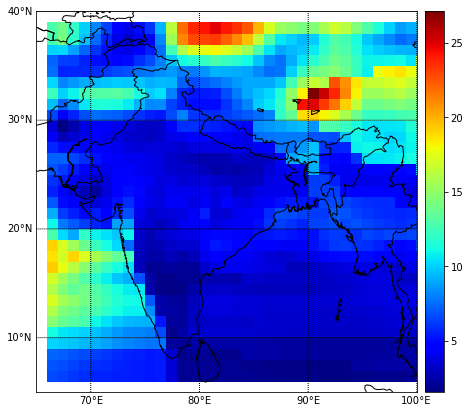

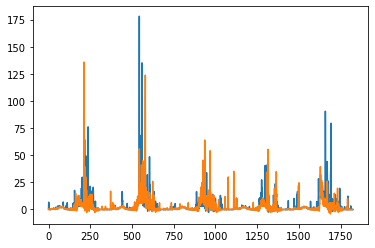

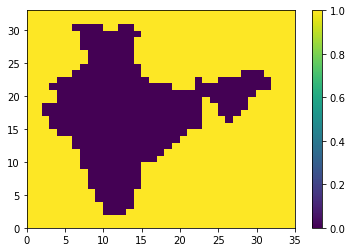

In [22]:
# plot spatial
map_bounds=data_bounds
mp_spacing=10
uu.map_plot_cyl(np.mean(data_bcsd_pred[:,:,:],axis=0),lat_obs,lon_obs,map_bounds,mp_spacing=10)

# plot temporal
plt.plot(data_bcsd_pred[:365*5,15,15])
plt.plot(data_bcsd_pred[-365*5:,15,15])

# plot mask
plt.figure()
plt.pcolor(mask)
plt.colorbar()

## test


In [159]:
# del data_bcsd_pred
out_id='gcm_'+gcm_name+'_imd'
data_gcm_bc_pred=(np.load(path_out + '/BC_outputs_full_'+out_id+'.npy'))
data_gcm_bc_pred  =  correct_nan_inf_neg_sts(data_gcm_bc_pred)

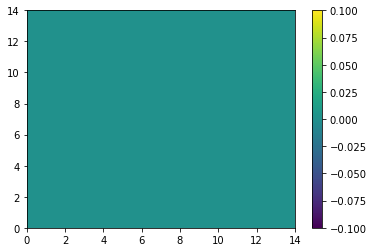

In [160]:
plt.pcolor(np.isnan(data_gcm_bc_pred[:,:,:]).sum(axis=0))
plt.colorbar()

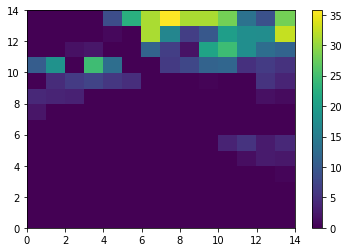

In [161]:
# data_gcm_bc_pred[:,7,7]=10000
plt.pcolor(data_gcm_bc_pred[3,:,:])
plt.colorbar()
# plt.pcolor(np.mean(data_gcm_bc_pred,axis=0))
# plt.colorbar()
# plt.figure()
# plt.pcolor(np.mean(data_gcm_bc_pred,axis=0))
# plt.colorbar()

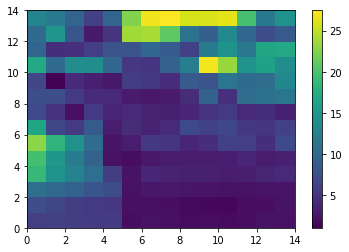

In [110]:
plt.pcolor(np.sum(np.isnan(data_gcm_bc_pred[:,:,:]),axis=0),cmap='jet')
plt.pcolor(np.mean(data_gcm_bc_pred,axis=0))
plt.colorbar()
# data_gcm_bc_pred[11,:,:]

## BCSD RND

In [21]:
mag=np.mean(data_obs_imd_train)*0.05
print(mag)
 
rdn=np.random.randn(data_gcm_train.shape[0],data_gcm_train.shape[1],data_gcm_train.shape[2])
data_0_train=mag*rdn*20
rdn=np.random.randn(data_gcm_pred.shape[0],data_gcm_pred.shape[1],data_gcm_pred.shape[2])
data_0_pred=mag*rdn*20
 
rdn=np.random.randn(data_gcm_train.shape[0],data_gcm_train.shape[1],data_gcm_train.shape[2])
data_1_train=mag*rdn*20
rdn=np.random.randn(data_gcm_pred.shape[0],data_gcm_pred.shape[1],data_gcm_pred.shape[2])
data_1_pred=mag*rdn*20
 
rdn=np.random.randn(data_gcm_train.shape[0],data_gcm_train.shape[1],data_gcm_train.shape[2])
data_2_train=mag*rdn*20
rdn=np.random.randn(data_gcm_pred.shape[0],data_gcm_pred.shape[1],data_gcm_pred.shape[2])
data_2_pred=mag*rdn*20

 
rdn=np.random.randn(data_gcm_train.shape[0],data_gcm_train.shape[1],data_gcm_train.shape[2])
data_3_train=mag*rdn*20
rdn=np.random.randn(data_gcm_pred.shape[0],data_gcm_pred.shape[1],data_gcm_pred.shape[2])
data_3_pred=mag*rdn*20

0.2054643871160917


In [22]:
data_bcsd_pred01 = bcsd('exp_0_run_0_imd',data_obs_imd_train,data_obs_imd_pred,data_0_train,data_0_pred,dic,mode=1)

bias_corr_spatial_daily:
Input size :  [(18262, 14, 14), (18262, 14, 14), (20089, 14, 14)]
Leapyear removed (18250, 14, 14) (18250, 14, 14) (20075, 14, 14)
Reshaped (365, 50, 14, 14) (365, 50, 14, 14) (365, 55, 14, 14)
Appended (395, 50, 14, 14) (395, 55, 14, 14) (395, 50, 14, 14)
14 14
BC: 7.142857142857142 % completed
BC: 14.285714285714285 % completed
BC: 21.428571428571427 % completed
BC: 28.57142857142857 % completed
BC: 35.714285714285715 % completed
BC: 42.857142857142854 % completed
BC: 50.0 % completed
BC: 57.14285714285714 % completed
BC: 64.28571428571429 % completed
BC: 71.42857142857143 % completed
BC: 78.57142857142857 % completed
BC: 85.71428571428571 % completed
BC: 92.85714285714286 % completed
BC: 100.0 % completed
SD: 0.004977848573846384 % completed
SD: 0.5027627059584847 % completed
SD: 1.0005475633431231 % completed
SD: 1.4983324207277615 % completed
SD: 1.9961172781123997 % completed
SD: 2.4939021354970383 % completed
SD: 2.9916869928816765 % completed
SD: 3.4894

In [23]:
del data_bcsd_pred01

In [24]:
data_bcsd_pred02 = bcsd('exp_0_run_1_imd',data_obs_imd_train,data_obs_imd_pred,data_1_train,data_1_pred,dic,mode=1)

bias_corr_spatial_daily:
Input size :  [(18262, 14, 14), (18262, 14, 14), (20089, 14, 14)]
Leapyear removed (18250, 14, 14) (18250, 14, 14) (20075, 14, 14)
Reshaped (365, 50, 14, 14) (365, 50, 14, 14) (365, 55, 14, 14)
Appended (395, 50, 14, 14) (395, 55, 14, 14) (395, 50, 14, 14)
14 14
BC: 7.142857142857142 % completed
BC: 14.285714285714285 % completed
BC: 21.428571428571427 % completed
BC: 28.57142857142857 % completed
BC: 35.714285714285715 % completed
BC: 42.857142857142854 % completed
BC: 50.0 % completed
BC: 57.14285714285714 % completed
BC: 64.28571428571429 % completed
BC: 71.42857142857143 % completed
BC: 78.57142857142857 % completed
BC: 85.71428571428571 % completed
BC: 92.85714285714286 % completed
BC: 100.0 % completed
SD: 0.004977848573846384 % completed
SD: 0.5027627059584847 % completed
SD: 1.0005475633431231 % completed
SD: 1.4983324207277615 % completed
SD: 1.9961172781123997 % completed
SD: 2.4939021354970383 % completed
SD: 2.9916869928816765 % completed
SD: 3.4894

In [25]:
del data_bcsd_pred02

In [26]:
data_bcsd_pred03 = bcsd('exp_0_run_2_imd',data_obs_imd_train,data_obs_imd_pred,data_2_train,data_2_pred,dic,mode=1)

bias_corr_spatial_daily:
Input size :  [(18262, 14, 14), (18262, 14, 14), (20089, 14, 14)]
Leapyear removed (18250, 14, 14) (18250, 14, 14) (20075, 14, 14)
Reshaped (365, 50, 14, 14) (365, 50, 14, 14) (365, 55, 14, 14)
Appended (395, 50, 14, 14) (395, 55, 14, 14) (395, 50, 14, 14)
14 14
BC: 7.142857142857142 % completed
BC: 14.285714285714285 % completed
BC: 21.428571428571427 % completed
BC: 28.57142857142857 % completed
BC: 35.714285714285715 % completed
BC: 42.857142857142854 % completed
BC: 50.0 % completed
BC: 57.14285714285714 % completed
BC: 64.28571428571429 % completed
BC: 71.42857142857143 % completed
BC: 78.57142857142857 % completed
BC: 85.71428571428571 % completed
BC: 92.85714285714286 % completed
BC: 100.0 % completed
SD: 0.004977848573846384 % completed
SD: 0.5027627059584847 % completed
SD: 1.0005475633431231 % completed
SD: 1.4983324207277615 % completed
SD: 1.9961172781123997 % completed
SD: 2.4939021354970383 % completed
SD: 2.9916869928816765 % completed
SD: 3.4894

In [27]:
data_bcsd_pred04 = bcsd('exp_0_run_3_imd',data_obs_imd_train,data_obs_imd_pred,data_3_train,data_3_pred,dic,mode=1)

bias_corr_spatial_daily:
Input size :  [(18262, 14, 14), (18262, 14, 14), (20089, 14, 14)]
Leapyear removed (18250, 14, 14) (18250, 14, 14) (20075, 14, 14)
Reshaped (365, 50, 14, 14) (365, 50, 14, 14) (365, 55, 14, 14)
Appended (395, 50, 14, 14) (395, 55, 14, 14) (395, 50, 14, 14)
14 14
BC: 7.142857142857142 % completed
BC: 14.285714285714285 % completed
BC: 21.428571428571427 % completed
BC: 28.57142857142857 % completed
BC: 35.714285714285715 % completed
BC: 42.857142857142854 % completed
BC: 50.0 % completed
BC: 57.14285714285714 % completed
BC: 64.28571428571429 % completed
BC: 71.42857142857143 % completed
BC: 78.57142857142857 % completed
BC: 85.71428571428571 % completed
BC: 92.85714285714286 % completed
BC: 100.0 % completed
SD: 0.004977848573846384 % completed
SD: 0.5027627059584847 % completed
SD: 1.0005475633431231 % completed
SD: 1.4983324207277615 % completed
SD: 1.9961172781123997 % completed
SD: 2.4939021354970383 % completed
SD: 2.9916869928816765 % completed
SD: 3.4894

# Junk

In [ ]:
import numpy as np
data_gcm_bc_pred=np.load('/content/drive/MyDrive/BiasCorr/BC_outputs.npy')
data_gcm_bc_pred_full=add_leap_years_sts(data_gcm_bc_pred,yr_split,en)[0]

data_bcsd_pred=np.load('/content/drive/MyDrive/BiasCorr/BCSD_outputs.npy')


import matplotlib.pyplot as plt


plt.matshow(data_bcsd_pred[7304,:,:])
plt.figure()
plt.matshow(data_gcm_bc_pred_full[7304,:,:])
plt.figure()
plt.plot(data_bcsd_pred[:365*2,10,11])
plt.plot(data_gcm_bc_pred_full[:365*2,7,7])

In [ ]:

rdn=np.random.randn(data_gcm_train.shape[0],data_gcm_train.shape[1],data_gcm_train.shape[2])
data_1=data_gcm_mon_train+1*mag*rdn
rdn=np.random.randn(data_gcm_train.shape[0],data_gcm_train.shape[1],data_gcm_train.shape[2])
data_2=data_gcm_mon_train+3*mag*rdn
rdn=np.random.randn(data_gcm_train.shape[0],data_gcm_train.shape[1],data_gcm_train.shape[2])
data_3=data_gcm_mon_train+5*mag*rdn

mag=np.mean(data_gcm_mon_pred)*0.05
print(mag)
rdn=np.random.randn(data_gcm_mon_pred.shape[0],data_gcm_mon_pred.shape[1],data_gcm_mon_pred.shape[2])
data_00=mag*rdn*20

rdn=np.random.randn(data_gcm_mon_pred.shape[0],data_gcm_mon_pred.shape[1],data_gcm_mon_pred.shape[2])
data_10=data_gcm_mon_pred+1*mag*rdn

rdn=np.random.randn(data_gcm_mon_pred.shape[0],data_gcm_mon_pred.shape[1],data_gcm_mon_pred.shape[2])
data_20=data_gcm_mon_pred+3*mag*rdn

rdn=np.random.randn(data_gcm_mon_pred.shape[0],data_gcm_mon_pred.shape[1],data_gcm_mon_pred.shape[2])
data_30=data_gcm_mon_pred+5*mag*rdn

data_bcsd_pred = bcsd(data_obs_ncar_mon_train,data_obs_ncar_mon_pred,data_gcm_mon_train,data_gcm_mon_pred)
data_bcsd_pred1 = bcsd(data_obs_ncar_mon_train,data_obs_ncar_mon_pred,data_1,data_10)
data_bcsd_pred2 = bcsd(data_obs_ncar_mon_train,data_obs_ncar_mon_pred,data_2,data_20)
data_bcsd_pred3 = bcsd(data_obs_ncar_mon_train,data_obs_ncar_mon_pred,data_3,data_30)


In [ ]:
data_gcm_bc_pred=np.load('/content/drive/MyDrive/BiasCorr/bias_corr_outputs.npy',allow_pickle=True)

print(data_gcm_bc_pred.shape)
plt.plot(data_gcm_bc_pred[:365,0,0])

In [ ]:
data_obs_ncar_train_coarse=np.zeros((data_obs_ncar_train.shape[0],data_gcm_train.shape[1],data_gcm_train.shape[2]))
for i in range(data_obs_ncar_train.shape[0]):
    data_obs_ncar_train_coarse[i,:,:]=regrid(data_obs_ncar_train[i,:,:],lat_obs,lon_obs,lat_gcm,lon_gcm)
data_gcm_bc_pred=bias_corr_spatial(data_obs_ncar_train_coarse,data_gcm_train,data_gcm_pred)

#uu.map_plot_cyl(data_obs_ncar_mon[0,:,:],lat_obs,lon_obs,map_bounds,mp_spacing=10)
#uu.map_plot_cyl(data_obs_ncar_mon_train_coarse[0,:,:],lat_gcm,lon_gcm,map_bounds,mp_spacing=10)
